In [2]:
import time

# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# train, test, validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix

# models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier



# scaling
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer

# decomposition
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF

# feature engineering
from sklearn.preprocessing import PolynomialFeatures

# feature selection
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE

In [3]:
train_df = pd.read_csv('../input/train.csv')
test_df = pd.read_csv('../input/test.csv')
combine = [train_df, test_df]

In [4]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


----
# modify features

## make ticket length feature
https://www.kaggle.com/yuanxuan/titanic-random-forest-82-78/notebook

In [5]:
train_df['Ticket_Len'] = train_df['Ticket'].apply(lambda x: len(x))
test_df['Ticket_Len'] = test_df['Ticket'].apply(lambda x: len(x))
combine = [train_df, test_df]

## make Cabin First character feature

In [6]:
train_df["Cabin_Letter"] = train_df["Cabin"].fillna('0').apply(lambda x: x[0])
test_df["Cabin_Letter"] = test_df["Cabin"].fillna('0').apply(lambda x: x[0])
combine = [train_df, test_df]

### make dummy variable for Cabin_Letter

In [7]:
train_test_df = pd.concat((train_df, test_df))

print(train_test_df.shape)

# apply get_dummies for Cabin_Letter
train_test_df = pd.get_dummies(train_test_df, columns=["Cabin_Letter"])

#train_test_df.head()
train_df = train_test_df.iloc[:train_df.shape[0]]
test_df = train_test_df.iloc[train_df.shape[0]:]

# drop added Survived column from test_df
test_df = test_df.drop("Survived", axis=1)
print(train_df.shape, test_df.shape)

combine = [train_df, test_df]

(1309, 14)
(891, 22) (418, 21)


## make CabinBool feature
**I think the idea here is that people with recorded cabin numbers are of higher socioeconomic class, and thus more likely to survive. **
https://www.kaggle.com/nadintamer/titanic-survival-predictions-beginner

- I tried it
  - but gradient boosting result became worse. from 0.79904 to 0.77990
  - more than cabinbool is necessary? should i use first letter of cabin name?

## make Cabin number feature
https://www.kaggle.com/yuanxuan/titanic-random-forest-82-78/notebook

In [8]:
for i in [train_df, test_df]:
    i['Cabin_num1'] = i['Cabin'].apply(lambda x: str(x).split(' ')[-1][1:])
    i['Cabin_num1'].replace('an', np.NaN, inplace = True)
    i['Cabin_num1'] = i['Cabin_num1'].apply(lambda x: int(x) if not pd.isnull(x) and x != '' else np.NaN)
    i['Cabin_num'] = pd.qcut(train_df['Cabin_num1'], 3)
    i['Cabin_num'] = i['Cabin_num'].cat.add_categories(["nan_category"])
    i['Cabin_num'] = i['Cabin_num'].fillna("nan_category")

/home/yuki/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/yuki/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/home/yuki/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing

In [9]:
train_df = pd.concat((train_df, pd.get_dummies(train_df['Cabin_num'], prefix='Cabin_num')), axis = 1)
test_df = pd.concat((test_df, pd.get_dummies(test_df['Cabin_num'], prefix='Cabin_num')), axis = 1)

In [10]:
del train_df['Cabin_num']
del test_df['Cabin_num']
del train_df['Cabin_num1']
del test_df['Cabin_num1']

**duplicate feature. delete one of these**

In [11]:
train_df.drop("Cabin_Letter_0", axis=1)
test_df.drop("Cabin_Letter_0", axis=1)
combine = [train_df, test_df]

## del Ticket, Cabin columns

In [12]:
# del Ticket, Cabin columns
train_df = train_df.drop(['Ticket', 'Cabin'], axis=1)
test_df = test_df.drop(['Ticket', 'Cabin'], axis=1)
combine = [train_df, test_df]

## add title

In [13]:
# add title
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

## make name length feature

In [14]:
train_df['Name_Len'] = train_df['Name'].apply(lambda x: len(x))
test_df['Name_Len'] = test_df['Name'].apply(lambda x: len(x))
combine = [train_df, test_df]

## map value to Sex 

In [15]:
for dataset in combine:
    dataset["Sex"] = dataset["Sex"].map({'female':1, 'male':0}).astype(int)

## make Age_Null_Flag if the Age is nulll

In [16]:
train_df['Age_Null_Flag'] = train_df['Age'].apply(lambda x: 1 if pd.isnull(x) else 0)
test_df['Age_Null_Flag'] = test_df['Age'].apply(lambda x: 1 if pd.isnull(x) else 0)
combine = [train_df, test_df]

## fill na of Age

options

- by Sex and Pclass
- by Title and Pclass

### by Sex and Pclass

### fill nan of Age by Title and Pclass
https://www.kaggle.com/yuanxuan/titanic-random-forest-82-78/notebook

There is mistake in the original notebook.
test_df was filled by train_df.
So I will skip it.

In [ ]:
# todo
train_test_df = pd.concat((train_df, test_df))
groupedAge_train_test = train_df.groupby(['Title', 'Pclass'])['Age']

train_df['Age'] = data.transform(lambda x: x.fillna(x.mean()))
test_df['Age'] = data.transform(lambda x: x.fillna(x.mean()))

#### tried keep Age feature and don't add AgeBand numerical feature
if both are there, it is duplicate information

#### 2018/03/17 tried Age instead of Age band. But AgeBand is better score for almost all models.
svc score was same of little bit better.
random forest score became worse.
so AgeBand is better

### add age band

- 5 age band by pd.cut
- 10 age band by pd.cut: this is better score.

if i use pd.qcut, band become too short for young adult around 25.

In [86]:
pd.cut(train_df['Age'], 10).value_counts()

(24.294, 32.252]    260
(16.336, 24.294]    179
(32.252, 40.21]     136
(40.21, 48.168]      99
(8.378, 16.336]      79
(0.34, 8.378]        58
(48.168, 56.126]     45
(56.126, 64.084]     24
(64.084, 72.042]      9
(72.042, 80.0]        2
Name: Age, dtype: int64

In [87]:
train_df['AgeBand'] = pd.cut(train_df['Age'], 10)

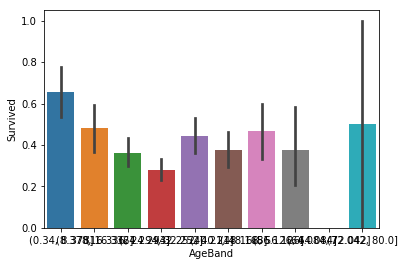

In [88]:
sns.barplot(x="AgeBand", data=train_df, y="Survived")

### Overwrite AgeBand number on Age. means, drop Age and AgeBand text column

In [89]:
# 5 age band
for dataset in combine:
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4
train_df = train_df.drop(['AgeBand'], axis=1)
combine = [train_df, test_df]

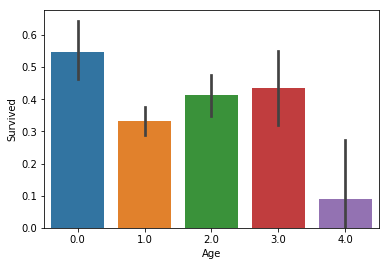

In [90]:
sns.barplot(data=train_df, x="Age", y="Survived")

----

## convert Title to numerical or one hot encoding

- one hot encoding, no deleting rare title
- OR change rare title to "Rare" and map value

### one hot encoding, no deleteing rare title

In [91]:
# try one hote encoding without delete rare title
#
# concat train and test data. and apply get_dummies for Title. 
# then split to original size. also drop Survived column from test_df
print(train_df.shape, test_df.shape)

# concat train and test data
#   test_df's Survived column is filled with NaN
train_test_df = pd.concat((train_df, test_df))

print(train_test_df.shape)

# apply get_dummies for Title
train_test_df = pd.get_dummies(train_test_df, columns=["Title"])

#train_test_df.head()
train_df = train_test_df.iloc[:train_df.shape[0]]
test_df = train_test_df.iloc[train_df.shape[0]:]

# drop added Survived column from test_df
test_df = test_df.drop("Survived", axis=1)
print(train_df.shape, test_df.shape)

combine = [train_df, test_df]

(891, 27) (418, 26)
(1309, 27)
(891, 44) (418, 43)


### OR change rare title to "Rare" and map value

## Create new feature "FamilySize"

In [92]:
for dataset in combine:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

for dataset in combine:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

for dataset in combine:
    dataset['Age*Class'] = dataset.Age * dataset.Pclass

/home/yuki/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/yuki/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/yuki/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs

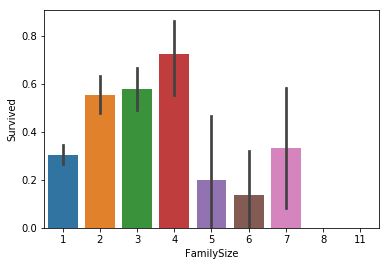

In [93]:
sns.barplot(data=train_df, x="FamilySize", y="Survived")

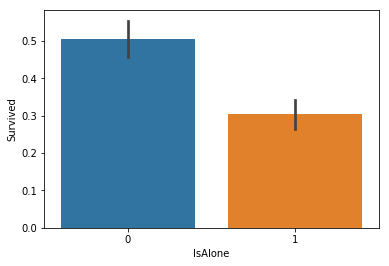

In [94]:
sns.barplot(data=train_df, x="IsAlone", y="Survived")

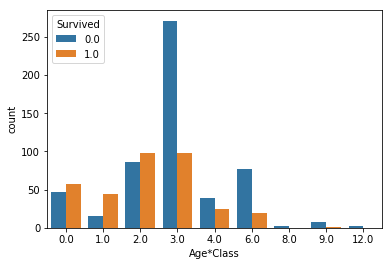

In [95]:
sns.countplot(data=train_df, x="Age*Class", hue="Survived")

In [96]:
train_df.head()

,Age,Age_Null_Flag,Cabin_Letter_0,Cabin_Letter_A,Cabin_Letter_B,Cabin_Letter_C,Cabin_Letter_D,Cabin_Letter_E,Cabin_Letter_F,Cabin_Letter_G,...,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_Sir,FamilySize,IsAlone,Age*Class
0,1.0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,2,0,3.0
1,2.0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,2,0,2.0
2,1.0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,3.0
3,2.0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,2,0,2.0
4,2.0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,1,6.0


### select family related feature
Parch, SibSp, FaimilySize, IsAlone

2018/03/18 Parch and SibSp only was best for almost all models

In [97]:
# keep Parch, SibSp only. this was best amoung familly related features

train_df = train_df.drop(['FamilySize', 'IsAlone'], axis=1)
test_df = test_df.drop(['FamilySize', 'IsAlone'], axis=1)
combine = [train_df, test_df]

## fill missing Embarked 

In [98]:
freq_port = train_df.Embarked.dropna().mode()[0]
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)

## Converting Embarked categorical feature to numeric

## try one hot encoding for Embarked categorical feature
2018/03/18 this is better than using converting categorical to numeric

In [99]:
# try one hote encoding for Embarked
#
# concat train and test data. and apply get_dummies for Title. 
# then split to original size. also drop Survived column from test_df
print(train_df.shape, test_df.shape)

# concat train and test data
#   test_df's Survived column is filled with NaN
train_test_df = pd.concat((train_df, test_df))

print(train_test_df.shape)

# apply get_dummies for Title
train_test_df = pd.get_dummies(train_test_df, columns=["Embarked"])

#train_test_df.head()
train_df = train_test_df.iloc[:train_df.shape[0]]
test_df = train_test_df.iloc[train_df.shape[0]:]

# drop added Survived column from test_df
test_df = test_df.drop("Survived", axis=1)
print(train_df.shape, test_df.shape)

combine = [train_df, test_df]

(891, 45) (418, 44)
(1309, 45)
(891, 47) (418, 46)


## fill na of test data Fare

In [100]:
test_df['Fare'].fillna(test_df['Fare'].dropna().median(), inplace=True)

## make Fareband feature

In [101]:
train_df['FareBand'] = pd.qcut(train_df['Fare'], 4)

for dataset in combine:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

train_df = train_df.drop(['FareBand'], axis=1)

combine = [train_df, test_df]

/home/yuki/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/yuki/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/yuki/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

### try more fare band number

- no difference

### keep Fare feature and add FareBand numerical feature¶

- not good result

## drop Name, PassengerId

In [102]:
train_df = train_df.drop(['Name', 'PassengerId'], axis=1)
test_df = test_df.drop(['Name'], axis=1)
combine = [train_df, test_df]

## final check data

In [103]:
train_df.head()

,Age,Age*Class,Age_Null_Flag,Cabin_Letter_0,Cabin_Letter_A,Cabin_Letter_B,Cabin_Letter_C,Cabin_Letter_D,Cabin_Letter_E,Cabin_Letter_F,...,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_Sir,Embarked_C,Embarked_Q,Embarked_S
0,1.0,3.0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1,2.0,2.0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,1,0,0
2,1.0,3.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,2.0,2.0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
4,2.0,6.0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


In [104]:
test_df.head()

,Age,Age*Class,Age_Null_Flag,Cabin_Letter_0,Cabin_Letter_A,Cabin_Letter_B,Cabin_Letter_C,Cabin_Letter_D,Cabin_Letter_E,Cabin_Letter_F,...,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_Sir,Embarked_C,Embarked_Q,Embarked_S
0,1.0,3.0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
1,2.0,6.0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2,1.0,2.0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
3,2.0,6.0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
4,2.0,6.0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1


----
# try to delete some features

- Age*Class is duplicated

In [105]:
train_df = train_df.drop(['Age*Class'], axis=1)
test_df = test_df.drop(['Age*Class'], axis=1)

In [106]:
print(train_df.shape, test_df.shape)
print(train_df.columns, test_df.columns)

(891, 44) (418, 44)
Index(['Age', 'Age_Null_Flag', 'Cabin_Letter_0', 'Cabin_Letter_A',
       'Cabin_Letter_B', 'Cabin_Letter_C', 'Cabin_Letter_D', 'Cabin_Letter_E',
       'Cabin_Letter_F', 'Cabin_Letter_G', 'Cabin_Letter_T',
       'Cabin_num_(1.999, 28.667]', 'Cabin_num_(28.667, 65.667]',
       'Cabin_num_(65.667, 148.0]', 'Cabin_num_nan_category', 'Fare',
       'Name_Len', 'Parch', 'Pclass', 'Sex', 'SibSp', 'Survived', 'Ticket_Len',
       'Title_Capt', 'Title_Col', 'Title_Countess', 'Title_Don', 'Title_Dona',
       'Title_Dr', 'Title_Jonkheer', 'Title_Lady', 'Title_Major',
       'Title_Master', 'Title_Miss', 'Title_Mlle', 'Title_Mme', 'Title_Mr',
       'Title_Mrs', 'Title_Ms', 'Title_Rev', 'Title_Sir', 'Embarked_C',
       'Embarked_Q', 'Embarked_S'],
      dtype='object') Index(['Age', 'Age_Null_Flag', 'Cabin_Letter_0', 'Cabin_Letter_A',
       'Cabin_Letter_B', 'Cabin_Letter_C', 'Cabin_Letter_D', 'Cabin_Letter_E',
       'Cabin_Letter_F', 'Cabin_Letter_G', 'Cabin_Letter_T',

In [107]:
train_df.head()

,Age,Age_Null_Flag,Cabin_Letter_0,Cabin_Letter_A,Cabin_Letter_B,Cabin_Letter_C,Cabin_Letter_D,Cabin_Letter_E,Cabin_Letter_F,Cabin_Letter_G,...,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_Sir,Embarked_C,Embarked_Q,Embarked_S
0,1.0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1,2.0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
2,1.0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,2.0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
4,2.0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


In [108]:
test_df.head()

,Age,Age_Null_Flag,Cabin_Letter_0,Cabin_Letter_A,Cabin_Letter_B,Cabin_Letter_C,Cabin_Letter_D,Cabin_Letter_E,Cabin_Letter_F,Cabin_Letter_G,...,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_Sir,Embarked_C,Embarked_Q,Embarked_S
0,1.0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
1,2.0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2,1.0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
3,2.0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
4,2.0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1


----

# model and estimate

In [109]:
X_train_df = train_df.drop("Survived", axis=1)
y_train_df = train_df["Survived"]

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X_train_df, y_train_df, test_size=0.33, random_state=42)
print("train/test data shape", X_train.shape, X_test.shape)

train/test data shape (596, 43) (295, 43)


## SVC

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=3)]: Done  82 tasks      | elapsed:    3.1s
[Parallel(n_jobs=3)]: Done 320 out of 320 | elapsed:   13.5s finished


Mean cross-validated score of the best_estimator:  0.8120805369127517
best parameters: {'C': 100, 'gamma': 0.001}
test:  0.8305084745762712


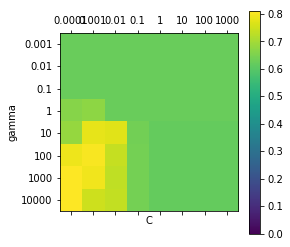

In [111]:
# make wide the ranges

param_grid = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}

grid_search = GridSearchCV(SVC(), param_grid, cv=5, n_jobs=3, verbose=1)

# no meaning to use cross_val for grid_search model because it is incluced in grid search
#scores = cross_val_score(grid_search, X_train, y_train, cv=5, n_jobs=6)
#print("mean of train scores", scores.mean())

grid_search.fit(X_train, y_train)

plt.matshow(grid_search.cv_results_['mean_test_score'].reshape(8, -1),
            vmin=0, cmap="viridis")
plt.xlabel("C")
plt.ylabel("gamma")
plt.xticks(range(len(param_grid['C'])), param_grid['C'])
plt.yticks(range(len(param_grid['gamma'])), param_grid['gamma'])
plt.colorbar()

print("Mean cross-validated score of the best_estimator: ", grid_search.best_score_)
print("best parameters:", grid_search.best_params_)
print("test: ", grid_search.score(X_test, y_test))

## KNeighborsClassifier

In [112]:
param_grid = {'kneighborsclassifier__n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]}

pipe = make_pipeline(MinMaxScaler(), KNeighborsClassifier())

grid_search = GridSearchCV(pipe, param_grid, cv=5, n_jobs=3, verbose=1)
grid_search.fit(X_train, y_train)

print("Mean cross-validated score of the best_estimator: ", grid_search.best_score_)
print("best parameters:", grid_search.best_params_)
print("test: ", grid_search.score(X_test, y_test))

Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=3)]: Done  50 out of  55 | elapsed:    1.7s remaining:    0.2s
[Parallel(n_jobs=3)]: Done  55 out of  55 | elapsed:    1.9s finished


Mean cross-validated score of the best_estimator:  0.837248322147651
best parameters: {'kneighborsclassifier__n_neighbors': 8}
test:  0.823728813559322


## try several SVC, KNeighborsClassifier models and preprocessing conbinations

In [113]:
param_grid = dict(scaling=[None, MinMaxScaler(), RobustScaler()],
                  reduce_dim=[None, PCA(), PCA(5), PCA(10), PCA(15), PCA(20), PCA(25)],
                  clf=[SVC(C=100, gamma=0.001), KNeighborsClassifier(n_neighbors=8)]
                 )
pipe = Pipeline([('scaling', StandardScaler()), ('reduce_dim', PCA()), ('clf', SVC())]) 

grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=3, verbose=1)
grid_search.fit(X_train, y_train)

print("Mean cross-validated score of the best_estimator: ", grid_search.best_score_)
print("best parameters:", grid_search.best_params_)
print("test: ", grid_search.score(X_test, y_test))

Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=3)]: Done  82 tasks      | elapsed:    6.7s


Mean cross-validated score of the best_estimator:  0.8439597315436241
best parameters: {'clf': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=8, p=2,
           weights='uniform'), 'reduce_dim': PCA(copy=True, iterated_power='auto', n_components=15, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), 'scaling': MinMaxScaler(copy=True, feature_range=(0, 1))}
test:  0.8067796610169492


[Parallel(n_jobs=3)]: Done 210 out of 210 | elapsed:   13.8s finished


----

# random forest result for compare

In [114]:
"""
param_grid = {'randomforestclassifier__n_estimators': [10, 50, 100, 300, 500, 1000],
              'randomforestclassifier__max_features': [1, 'auto', None],
             'randomforestclassifier__max_depth':[1, 3, 5, 7, 9, None],
             'randomforestclassifier__min_samples_leaf': [1,2,4],
             "randomforestclassifier__min_samples_split" : [2, 3, 4]}
"""
# very narrow range
param_grid = {'randomforestclassifier__n_estimators': [10,  100,  500, 1000],
              'randomforestclassifier__max_features': [1, 'auto', None],
             'randomforestclassifier__max_depth':[1, 3, 5, 7, None],
             'randomforestclassifier__min_samples_leaf': [1,2,4],
             "randomforestclassifier__min_samples_split" : [2, 3, 4]}

pipe = make_pipeline(RandomForestClassifier())

grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=3, verbose=1)
grid_search.fit(X_train, y_train)

print("Mean cross-validated score of the best_estimator: ", grid_search.best_score_)
print("best parameters:", grid_search.best_params_)
print("test: ", grid_search.score(X_test, y_test))

Fitting 5 folds for each of 540 candidates, totalling 2700 fits


[Parallel(n_jobs=3)]: Done  53 tasks      | elapsed:   30.0s


KeyboardInterrupt: 

In [ ]:
pipe = make_pipeline(RandomForestClassifier(max_depth=7, 
                                            max_features="auto",
                                            min_samples_leaf=1, 
                                            min_samples_split=3, 
                                            n_estimators=100))
pipe.fit(X_train, y_train)
print("test: ", pipe.score(X_test, y_test))

scores = cross_val_score(pipe, X_train_df, y_train_df, n_jobs=3)
print("mean of cross val score: ", scores.mean())

In [ ]:
pd.concat((pd.DataFrame(X_train.columns, columns = ['variable']), 
           pd.DataFrame(pipe.named_steps["randomforestclassifier"].feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)

### try several scaling and feature selections for random forest

**try scaling for random forest**

**try feature selection**

## XGBoost

## AdaBoostClassifier

## GradientBoostingClassifier

In [ ]:
pipe = make_pipeline(GradientBoostingClassifier(learning_rate=0.01,
                                                max_depth=6,
                                                max_features="sqrt",
                                                min_samples_leaf=3,
                                                min_samples_split=3,
                                                n_estimators=200))
pipe.fit(X_train, y_train)
print("test: ", pipe.score(X_test, y_test))

scores = cross_val_score(pipe, X_train_df, y_train_df, n_jobs=3)
print("mean of cross val score for X_train_df: ", scores.mean())

In [ ]:
pd.concat((pd.DataFrame(X_train.columns, columns = ['variable']), 
           pd.DataFrame(pipe.named_steps["gradientboostingclassifier"].feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)

### try scaling and feature selection

In [ ]:
param_grid = dict(scaling=[None, MinMaxScaler(), RobustScaler()],
                  reduce_dim=[None, PCA(), PCA(5), PCA(10), PCA(15), PCA(20), PCA(25), PCA(30)],
                  clf=[GradientBoostingClassifier(learning_rate=0.01,
                                                max_depth=6,
                                                max_features="sqrt",
                                                min_samples_leaf=3,
                                                min_samples_split=3,
                                                n_estimators=200)]
                 )
pipe = Pipeline([('scaling', StandardScaler()), ('reduce_dim', PCA()), ('clf', RandomForestClassifier())]) 

grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=3, verbose=1)
grid_search.fit(X_train, y_train)

print("Mean cross-validated score of the best_estimator: ", grid_search.best_score_)
print("best parameters:", grid_search.best_params_)
print("test: ", grid_search.score(X_test, y_test))

**try scaling for Gradient boosting**

**try feature selection**